<a href="https://colab.research.google.com/github/haileychoii/k-water_ready/blob/main/k_water_sihwa_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-water 공모전
> 주제 - 시화호 기후변화

## 필요 library 불러오기

In [449]:
import pandas as pd
import numpy as np

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
! pip install koreanize_matplotlib
import koreanize_matplotlib

# 머신 러닝 라이브러리
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# AutoML 라이브러리

!pip install pycaret
from pycaret.regression import *


# 시계열 분석 및 예측 라이브러리
import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import AR
# from fbprophet import Prophet
import tensorflow as tf
from tensorflow import keras
import scipy.stats as stats

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# import pmdarima as pm
import prophet

# 기타 유틸리티
import os
import datetime

In [ ]:
!pip install pycaret[analysis]

## dataset불러오기, 설명
* 데이터는 깃허브에 올려 두었음

In [ ]:
# 시화조력수문데이터
sihwa_sumun_df = pd.read_csv('https://raw.githubusercontent.com/haileychoii/k-water_ready/main/kwater_dataset/Kwater_exportData_2023-07-20.csv', encoding = 'cp949')

In [ ]:
sihwa_sumun_df.head()

,번호,일자,호수위(EL.m),해수위(EL.m)
0,364079,2023-07-20 08:40,-1.34,1.82
1,364078,2023-07-20 08:30,-1.38,2.04
2,364077,2023-07-20 08:20,-1.43,2.25
3,364076,2023-07-20 08:10,-1.48,2.49
4,364075,2023-07-20 08:00,-1.54,2.70


In [ ]:
# Convert '일자' to datetime format
sihwa_sumun_df['일자'] = pd.to_datetime(sihwa_sumun_df['일자'])

# 2023으로 시작하는 data만 추출
# Extract rows with '일자' starting with '2023'
X = sihwa_sumun_df[sihwa_sumun_df['일자'].dt.year == 2023]

# Display the result
print(X)

           번호                  일자  호수위(EL.m)  해수위(EL.m)
0      364079 2023-07-20 08:40:00      -1.34       1.82
1      364078 2023-07-20 08:30:00      -1.38       2.04
2      364077 2023-07-20 08:20:00      -1.43       2.25
3      364076 2023-07-20 08:10:00      -1.48       2.49
4      364075 2023-07-20 08:00:00      -1.54       2.70
...       ...                 ...        ...        ...
28834  335245 2023-01-01 00:40:00      -1.21       1.60
28835  335244 2023-01-01 00:30:00      -1.27       1.69
28836  335243 2023-01-01 00:20:00      -1.33       1.79
28837  335242 2023-01-01 00:10:00      -1.37       1.84
28838  335241 2023-01-01 00:00:00      -1.43       1.90

[28839 rows x 4 columns]


In [ ]:
sihwa_sumun_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364079 entries, 0 to 364078
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   번호         364079 non-null  int64         
 1   일자         364079 non-null  datetime64[ns]
 2   호수위(EL.m)  364079 non-null  float64       
 3   해수위(EL.m)  364079 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 11.1 MB


In [ ]:
# 안산시 일일 강우량 데이터
ansan_rain_df = pd.read_csv('https://raw.githubusercontent.com/haileychoii/k-water_ready/main/kwater_dataset/%EA%B2%BD%EA%B8%B0%EB%8F%84%20%EC%95%88%EC%82%B0%EC%8B%9C_%EC%9D%BC%EB%B3%84_%EA%B0%95%EC%9A%B0%EB%9F%89_20230112.csv')

In [ ]:
ansan_rain_df.head()

,시도명,시군구명,읍면동,날짜,우량(mm),관리기관명
0,안산시,상록구,안산동,2013-07-04,0.0,경기도 안산시청
1,안산시,상록구,안산동,2013-07-05,2.0,경기도 안산시청
2,안산시,상록구,안산동,2013-07-06,0.0,경기도 안산시청
3,안산시,상록구,안산동,2013-07-07,9.0,경기도 안산시청
4,안산시,상록구,안산동,2013-07-08,48.0,경기도 안산시청


In [ ]:
ansan_sh_rain_df = ansan_rain_df[ansan_rain_df['읍면동']=='대부남동']
ansan_sh_rain_df = ansan_sh_rain_df.drop(['관리기관명'], axis = 1)

In [ ]:
ansan_sh_rain_df['날짜'] = pd.to_datetime(ansan_sh_rain_df['날짜'])

In [ ]:
# 안산시 대부남동 강우량 일일 데이터
# ansan_sh_rain_df = ansan_sh_rain_df.rename(columns = {'날짜':'일자'}, inplace = True)

In [ ]:
ansan_sh_rain_df.head()

,시도명,시군구명,읍면동,날짜,우량(mm)
34692,안산시,단원구,대부남동,2013-01-02,0.0
34693,안산시,단원구,대부남동,2013-01-03,0.0
34694,안산시,단원구,대부남동,2013-01-04,0.5
34695,안산시,단원구,대부남동,2013-01-05,0.5
34696,안산시,단원구,대부남동,2013-01-06,0.0


In [ ]:
# 해양환경공단_해양수질자동측정망_시화조력(20211230)
water_quality_df = pd.read_csv('https://raw.githubusercontent.com/haileychoii/k-water_ready/main/kwater_dataset/%ED%95%B4%EC%96%91%ED%99%98%EA%B2%BD%EA%B3%B5%EB%8B%A8_%ED%95%B4%EC%96%91%EC%88%98%EC%A7%88%EC%9E%90%EB%8F%99%EC%B8%A1%EC%A0%95%EB%A7%9D%20%EC%8B%9C%ED%99%94%EC%A1%B0%EB%A0%A5_20211231.csv', encoding = 'cp949')

In [ ]:
# 관측일자 열 datetime으로 변경
water_quality_df['관측일자'] = pd.to_datetime(water_quality_df['관측일자'])

In [ ]:
water_quality_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103713 entries, 0 to 103712
Data columns (total 23 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   정점코드      103713 non-null  int64         
 1   관측일자      103713 non-null  datetime64[ns]
 2   전기전도도     103713 non-null  float64       
 3   수온        103713 non-null  float64       
 4   수소이온농도    103713 non-null  float64       
 5   용존산소량     103713 non-null  float64       
 6   탁도        103713 non-null  int64         
 7   일사량       103713 non-null  float64       
 8   기온        103713 non-null  float64       
 9   상대습도      103713 non-null  int64         
 10  풍속        103713 non-null  int64         
 11  풍향        103713 non-null  int64         
 12  강수량       103713 non-null  float64       
 13  염분        103713 non-null  float64       
 14  클로로필      103713 non-null  float64       
 15  화학적산소요구량  103713 non-null  float64       
 16  총질소       103713 non-null  float64    

In [ ]:
water_quality_df.head()

,정점코드,관측일자,전기전도도,수온,수소이온농도,용존산소량,탁도,일사량,기온,상대습도,...,염분,클로로필,화학적산소요구량,총질소,총인,암모니아질소,질산질소,인산성인,규산규소,남조류
0,102,2021-01-01 00:00:00,27.64,3.53,7.82,10.42,5,0.0,-4.37,0,...,32.45,1.25,3.52,0.542,0.041,0.099,0.215,0.035,0,0
1,102,2021-01-01 00:05:00,27.61,3.51,7.82,10.42,6,0.0,-4.37,0,...,32.43,1.17,3.52,0.542,0.041,0.099,0.215,0.035,0,0
2,102,2021-01-01 00:10:00,27.59,3.48,7.82,10.41,7,0.0,-4.45,0,...,32.44,0.57,3.52,0.542,0.041,0.099,0.215,0.035,0,0
3,102,2021-01-01 00:15:00,27.63,3.56,7.82,10.40,7,0.0,-4.40,0,...,32.40,1.16,3.52,0.542,0.041,0.099,0.215,0.035,0,0
4,102,2021-01-01 00:20:00,27.69,3.61,7.82,10.39,7,0.0,-4.54,0,...,32.44,0.88,3.52,0.542,0.041,0.099,0.215,0.035,0,0


In [ ]:
# 날짜별로 각 성분 평균 값 구하기
wq_sihwa_df = water_quality_df.groupby('관측일자').mean()
wq_sihwa_df.head()

,정점코드,전기전도도,수온,수소이온농도,용존산소량,탁도,일사량,기온,상대습도,풍속,...,염분,클로로필,화학적산소요구량,총질소,총인,암모니아질소,질산질소,인산성인,규산규소,남조류
관측일자,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,102.0,27.64,3.53,7.82,10.42,5.0,0.0,-4.37,0.0,0.0,...,32.45,1.25,3.52,0.542,0.041,0.099,0.215,0.035,0.0,0.0
2021-01-01 00:05:00,102.0,27.61,3.51,7.82,10.42,6.0,0.0,-4.37,0.0,0.0,...,32.43,1.17,3.52,0.542,0.041,0.099,0.215,0.035,0.0,0.0
2021-01-01 00:10:00,102.0,27.59,3.48,7.82,10.41,7.0,0.0,-4.45,0.0,0.0,...,32.44,0.57,3.52,0.542,0.041,0.099,0.215,0.035,0.0,0.0
2021-01-01 00:15:00,102.0,27.63,3.56,7.82,10.40,7.0,0.0,-4.40,0.0,0.0,...,32.40,1.16,3.52,0.542,0.041,0.099,0.215,0.035,0.0,0.0
2021-01-01 00:20:00,102.0,27.69,3.61,7.82,10.39,7.0,0.0,-4.54,0.0,0.0,...,32.44,0.88,3.52,0.542,0.041,0.099,0.215,0.035,0.0,0.0


In [ ]:
wq_sihwa_df.drop(['정점코드', '기온', '상대습도', '풍속', '풍향', '강수량', '규산규소', '남조류'], axis = 1, inplace = True)

In [ ]:
wq_sihwa_df.columns

Index(['전기전도도', '수온', '수소이온농도', '용존산소량', '탁도', '일사량', '염분', '클로로필', '화학적산소요구량',
       '총질소', '총인', '암모니아질소', '질산질소', '인산성인'],
      dtype='object')

In [ ]:
wq_sihwa_df

,전기전도도,수온,수소이온농도,용존산소량,탁도,일사량,염분,클로로필,화학적산소요구량,총질소,총인,암모니아질소,질산질소,인산성인
관측일자,,,,,,,,,,,,,,
2021-01-01 00:00:00,27.64,3.53,7.82,10.42,5.0,0.0,32.45,1.25,3.52,0.542,0.041,0.099,0.215,0.035
2021-01-01 00:05:00,27.61,3.51,7.82,10.42,6.0,0.0,32.43,1.17,3.52,0.542,0.041,0.099,0.215,0.035
2021-01-01 00:10:00,27.59,3.48,7.82,10.41,7.0,0.0,32.44,0.57,3.52,0.542,0.041,0.099,0.215,0.035
2021-01-01 00:15:00,27.63,3.56,7.82,10.40,7.0,0.0,32.40,1.16,3.52,0.542,0.041,0.099,0.215,0.035
2021-01-01 00:20:00,27.69,3.61,7.82,10.39,7.0,0.0,32.44,0.88,3.52,0.542,0.041,0.099,0.215,0.035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 23:35:00,28.35,4.15,7.84,9.35,5.0,0.0,32.74,0.71,1.67,0.404,0.047,0.103,0.255,0.033
2021-12-31 23:40:00,28.38,4.19,7.84,9.33,5.0,0.0,32.75,0.47,1.67,0.404,0.047,0.103,0.255,0.033
2021-12-31 23:45:00,28.40,4.20,7.84,9.34,5.0,0.0,32.76,1.11,1.67,0.404,0.047,0.103,0.255,0.033


In [ ]:
wq_sihwa_re_df = wq_sihwa_df.reset_index()

In [ ]:
# 일자별 시화호 댐 수문 방류량, 개문시작시간, 폐문종료시각 데이터
discharge_water_df = pd.read_csv('https://raw.githubusercontent.com/haileychoii/k-water_ready/main/kwater_dataset/%ED%95%9C%EA%B5%AD%EB%86%8D%EC%96%B4%EC%B4%8C%EA%B3%B5%EC%82%AC_%ED%99%94%EC%95%88%EC%82%AC%EC%97%85%EB%8B%A8_20230504.csv', encoding = 'cp949')

In [ ]:
# '일자'열 datetime으로 변경
discharge_water_df['일자'] = pd.to_datetime(discharge_water_df['일자'])
discharge_water_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   일자       99 non-null     datetime64[ns]
 1   개문시작시각   99 non-null     object        
 2   폐문종료시각   99 non-null     object        
 3   방류량(천톤)  99 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.2+ KB


In [ ]:
discharge_water_df.head()

,일자,개문시작시각,폐문종료시각,방류량(천톤)
0,2018-04-02,22:30,02:22,917.295
1,2018-04-04,12:00,23:09,747.897
2,2018-05-14,20:10,00:10,634.439
3,2018-05-16,21:13,01:22,917.295
4,2018-05-18,22:32,02:44,917.295


In [ ]:
# 방재기상관측데이터(평균기온, 최저기온, 최고기온, 평균풍속)
ansan_aws_df = pd.read_csv('https://raw.githubusercontent.com/haileychoii/k-water_ready/main/kwater_dataset/%EC%95%88%EC%82%B0_16-22_%EB%B0%A9%EC%9E%AC%EA%B8%B0%EC%83%81%EA%B4%80%EC%B8%A1%EB%8D%B0%EC%9D%B4%ED%84%B0(%ED%8F%89%EA%B7%A0%EA%B8%B0%EC%98%A8%2C%20%ED%92%8D%EC%86%8D).csv', encoding = 'cp949')
ansan_aws_df.head()

,지점,지점명,일시,평균기온(°C),최저기온(°C),최고기온(°C),평균 풍속(m/s)
0,545,안산,2016-07-01,23.7,21.4,27.1,1.8
1,545,안산,2016-07-02,23.0,20.5,26.9,2.3
2,545,안산,2016-07-03,22.0,19.0,26.1,0.8
3,545,안산,2016-07-04,21.7,19.3,23.0,1.6
4,545,안산,2016-07-05,23.4,21.1,25.6,2.3


In [ ]:
# 불필요한 '지점', '지점명' 열 제거
ansan_aws_df.drop(['지점', '지점명'], axis = 1, inplace = True)

In [ ]:
# '일시'열 datetime으로 변경
ansan_aws_df['일시'] = pd.to_datetime(ansan_aws_df['일시'])

In [ ]:
ansan_aws_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2358 entries, 0 to 2357
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   일시          2358 non-null   datetime64[ns]
 1   평균기온(°C)    2355 non-null   float64       
 2   최저기온(°C)    2353 non-null   float64       
 3   최고기온(°C)    2353 non-null   float64       
 4   평균 풍속(m/s)  2354 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 92.2 KB


In [ ]:
# 우리나라 기후평년값(안산, 2011~2020)
try:
    안산_기후평년값_df = pd.read_csv('https://raw.githubusercontent.com/haileychoii/k-water_ready/main/kwater_dataset/STCS_%EC%9A%B0%EB%A6%AC%EB%82%98%EB%9D%BC%EA%B8%B0%ED%9B%84%ED%8F%89%EB%85%84%EA%B0%92_DD_20230726081117.csv',skiprows = 4, header = 1, encoding = 'cp949')
except pd.errors.ParserError as e:
    print('ParserError:', e)

안산_기후평년값_df.head()

,지점명,일시,최저기온(°C),평균기온(°C),최고기온(°C),강수량(mm),습도(%),일조시간(hr)
0,안산,06-27,17.8,22.4,28.1,8.0,NaN,NaN
1,안산,06-28,18.2,22.6,28.1,10.6,NaN,NaN
2,안산,06-29,18.4,22.7,28.0,11.9,NaN,NaN
3,안산,06-30,18.7,22.9,28.1,14.1,NaN,NaN
4,안산,07-01,18.8,22.9,27.9,17.8,NaN,NaN


In [ ]:
# NaN값 제거
안산_기후평년값_df = 안산_기후평년값_df.dropna(axis = 1)
안산_기후평년값_df.drop('지점명', axis = 1,  inplace = True)
안산_기후평년값_df.head()

,일시,최저기온(°C),평균기온(°C),최고기온(°C),강수량(mm)
0,06-27,17.8,22.4,28.1,8.0
1,06-28,18.2,22.6,28.1,10.6
2,06-29,18.4,22.7,28.0,11.9
3,06-30,18.7,22.9,28.1,14.1
4,07-01,18.8,22.9,27.9,17.8


In [ ]:
안산_기후평년값_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   일시        30 non-null     object 
 1   최저기온(°C)  30 non-null     float64
 2   평균기온(°C)  30 non-null     float64
 3   최고기온(°C)  30 non-null     float64
 4   강수량(mm)   30 non-null     float64
dtypes: float64(4), object(1)
memory usage: 1.3+ KB


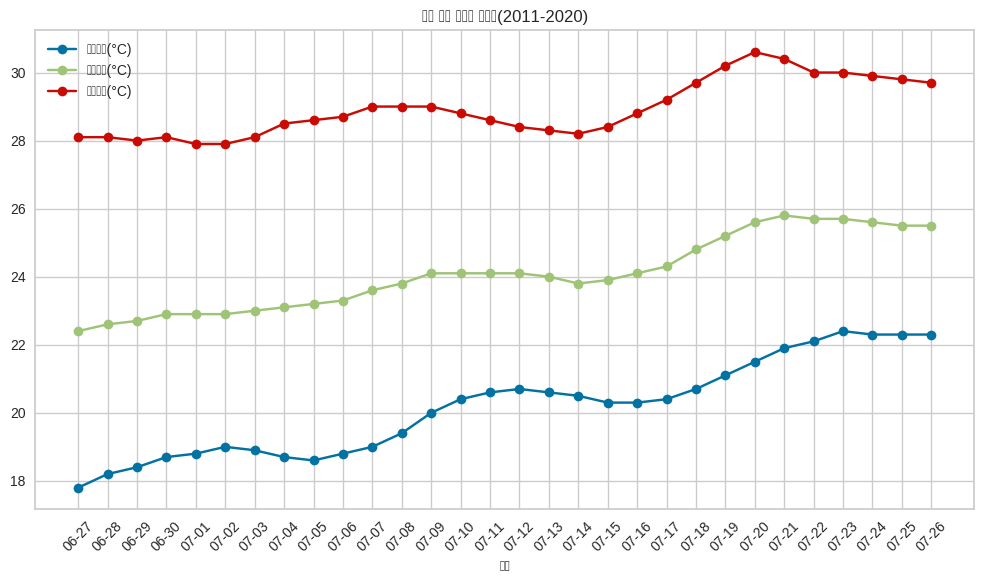

<Figure size 800x550 with 0 Axes>

In [ ]:

# Plotting
plt.figure(figsize=(10, 6))

# Plotting temperature data
plt.plot(안산_기후평년값_df['일시'],안산_기후평년값_df['최저기온(°C)'], marker='o', label='최저기온(°C)')
plt.plot(안산_기후평년값_df['일시'], 안산_기후평년값_df['평균기온(°C)'], marker='o', label='평균기온(°C)')
plt.plot(안산_기후평년값_df['일시'], 안산_기후평년값_df['최고기온(°C)'], marker='o', label='최고기온(°C)')

# Set x-axis label and title
plt.xlabel('일시')
plt.title('안산 기후 평년값 데이터(2011-2020)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
plt.savefig('안산기온평년값_11-20.png')

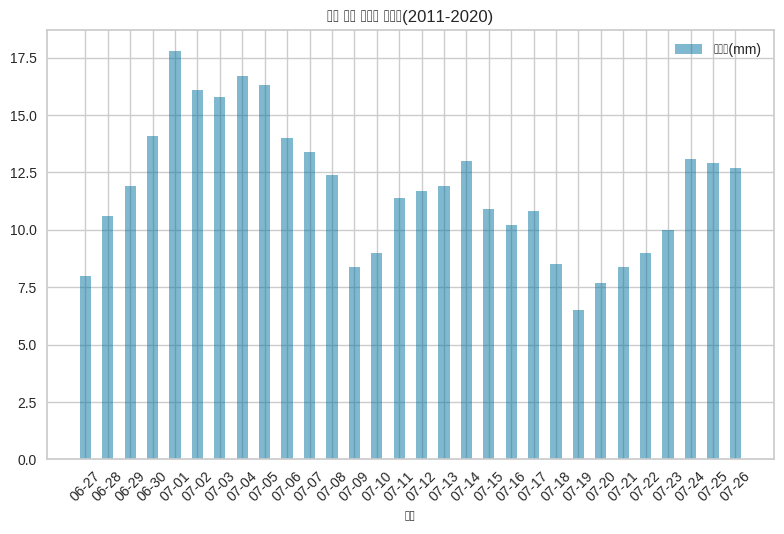

In [ ]:
# Plotting rainfall data as a bar plot
plt.bar(안산_기후평년값_df['일시'], 안산_기후평년값_df['강수량(mm)'], width=0.5, align='center', label='강수량(mm)', alpha=0.5)

# Set x-axis label and title
plt.xlabel('일시')
plt.title('안산 기후 평년값 데이터(2011-2020)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the legend
plt.legend()

plt.savefig('안산강수량평년값_11-20.png')

# Show the plot
plt.tight_layout()
plt.show()

------------------------------------------------------------------------


## data 전처리 - 데이터 합치기

> 들여쓴 블록


* 방류량(discharge) 데이터는 99개밖에 안되므로 옵션으로 넣기
* 기후 관련/ 기후 + 수질 관련/ 기후 + 수질 + 방류량 관련

### 시화수문데이터, 강수량 등

In [ ]:
# 시화 수문 데이터 기준

In [ ]:
# 안산시 대부남동 수문수위정보, 강수량, 기온 등 기후 data 정리
print(ansan_sh_rain_df.head())
print(sihwa_sumun_df.head())

       시도명 시군구명   읍면동         날짜  우량(mm)
34692  안산시  단원구  대부남동 2013-01-02     0.0
34693  안산시  단원구  대부남동 2013-01-03     0.0
34694  안산시  단원구  대부남동 2013-01-04     0.5
34695  안산시  단원구  대부남동 2013-01-05     0.5
34696  안산시  단원구  대부남동 2013-01-06     0.0
       번호                  일자  호수위(EL.m)  해수위(EL.m)
0  364079 2023-07-20 08:40:00      -1.34       1.82
1  364078 2023-07-20 08:30:00      -1.38       2.04
2  364077 2023-07-20 08:20:00      -1.43       2.25
3  364076 2023-07-20 08:10:00      -1.48       2.49
4  364075 2023-07-20 08:00:00      -1.54       2.70


In [ ]:
# 일단 두개 합침, 강수량 데이터 기준으로 일자별로 합쳐봄
merged_df = pd.merge(sihwa_sumun_df, ansan_sh_rain_df,left_on='일자', right_on='날짜')
merged_df.head()

,번호,일자,호수위(EL.m),해수위(EL.m),시도명,시군구명,읍면동,날짜,우량(mm)
0,335097,2022-12-31,-1.25,1.60,안산시,단원구,대부남동,2022-12-31,0.0
1,334953,2022-12-30,-1.16,1.04,안산시,단원구,대부남동,2022-12-30,0.0
2,334809,2022-12-29,-1.20,0.10,안산시,단원구,대부남동,2022-12-29,0.0
3,334665,2022-12-28,-1.03,-0.91,안산시,단원구,대부남동,2022-12-28,0.0
4,334521,2022-12-27,-1.76,-2.12,안산시,단원구,대부남동,2022-12-27,0.0


In [ ]:
merged_rain_df = merged_df.drop(['날짜', '번호', '시도명', '시군구명', '읍면동'], axis = 1)
# merged_df = merged_df.rename(columns = {'일자':'날짜'})
merged_rain_df.head()

,일자,호수위(EL.m),해수위(EL.m),우량(mm)
0,2022-12-31,-1.25,1.60,0.0
1,2022-12-30,-1.16,1.04,0.0
2,2022-12-29,-1.20,0.10,0.0
3,2022-12-28,-1.03,-0.91,0.0
4,2022-12-27,-1.76,-2.12,0.0


### 일자별 수문, 강수량, 기온, 평균풍속 merge

In [ ]:
# aws 더하기
merged_aws_df = pd.merge(merged_rain_df, ansan_aws_df, left_on = '일자', right_on = '일시')

In [ ]:
merged_aws_df.drop('일시', axis = 1, inplace = True)

In [ ]:
merged_aws_df.to_csv('kwater-aws.csv')

### 수질 데이터 추가

In [ ]:
# 안산의 방재기상데이터(merge_aws_df)와 merge
merged_wq_df = pd.merge(merged_aws_df, wq_sihwa_re_df, left_on='일자', right_on='관측일자')


In [ ]:
merged_wq_df.drop('관측일자', axis = 1, inplace = True)

In [ ]:
merged_wq_df.head()

,일자,호수위(EL.m),해수위(EL.m),우량(mm),평균기온(°C),최저기온(°C),최고기온(°C),평균 풍속(m/s),전기전도도,수온,...,탁도,일사량,염분,클로로필,화학적산소요구량,총질소,총인,암모니아질소,질산질소,인산성인
0,2021-12-31,-2.33,0.78,0.0,-5.9,-10.5,-2.2,1.7,28.90,4.80,...,4.0,0.0,32.80,0.52,1.36,0.368,0.046,0.090,0.260,0.034
1,2021-12-30,-1.71,1.76,0.0,-3.3,-9.1,0.7,1.4,29.29,5.30,...,2.0,0.0,32.78,0.21,1.05,0.421,0.045,0.114,0.259,0.034
2,2021-12-29,-1.24,2.19,1.0,0.2,-7.7,7.4,0.9,29.21,5.31,...,9.0,0.0,32.67,0.74,0.84,0.435,0.047,0.122,0.313,0.034
3,2021-12-28,-1.04,1.46,0.0,-4.9,-11.8,1.1,0.4,29.36,5.51,...,5.0,0.0,32.66,0.45,1.25,0.000,0.044,0.132,0.408,0.034
4,2021-12-27,-1.04,0.47,0.0,-8.4,-15.6,-3.2,0.5,29.41,5.67,...,13.0,0.0,32.57,0.44,1.83,0.554,0.051,0.089,0.239,0.034


In [ ]:
merged_wq_df.to_csv('kwater-wq.csv')

### 방류량 데이터 추가

In [ ]:
discharge_water_df.head()

,일자,개문시작시각,폐문종료시각,방류량(천톤)
0,2018-04-02,22:30,02:22,917.295
1,2018-04-04,12:00,23:09,747.897
2,2018-05-14,20:10,00:10,634.439
3,2018-05-16,21:13,01:22,917.295
4,2018-05-18,22:32,02:44,917.295


In [ ]:
merged_dis_df = merged_wq_df.merge(discharge_water_df, left_on= '일자', right_on = '일자')

In [ ]:
merged_dis_df.columns

Index(['일자', '호수위(EL.m)', '해수위(EL.m)', '우량(mm)', '평균기온(°C)', '최저기온(°C)',
       '최고기온(°C)', '평균 풍속(m/s)', '전기전도도', '수온', '수소이온농도', '용존산소량', '탁도', '일사량',
       '염분', '클로로필', '화학적산소요구량', '총질소', '총인', '암모니아질소', '질산질소', '인산성인',
       '개문시작시각', '폐문종료시각', '방류량(천톤)'],
      dtype='object')

In [ ]:
merged_dis_df.drop(['개문시작시각', '폐문종료시각', '최저기온(°C)',	'최고기온(°C)'], axis = 1, inplace = True)


In [ ]:
merged_dis_df.to_csv('kwater-dis.csv')

## 데이터 분석

### 전처리 마친 csv파일 불러오기

In [ ]:
# df1 -> 수위, 기후
df1 = pd.read_csv('https://raw.githubusercontent.com/haileychoii/k-water_ready/main/kwater-merged1.csv')
# df2 -> 수위, 기후, 수질
df2 = pd.read_csv('https://raw.githubusercontent.com/haileychoii/k-water_ready/main/merged_%EC%88%98%EC%A7%88_%EA%B8%B0%EC%98%A8%EA%B8%B0%EC%83%81.csv')
# df3 -> 수위, 기후, 수질, 방류량
df3 = pd.read_csv('https://raw.githubusercontent.com/haileychoii/k-water_ready/main/kwater_merged_%EB%B0%A9%EB%A5%98%EB%9F%89_%EC%88%98%EC%A7%881.csv', encoding = 'cp949')

### 2-1. df1-시화수문, 일일 기후 data

In [ ]:
df1.head()

,일자,호수위(EL.m),해수위(EL.m),우량(mm),평균기온(°C),최저기온(°C),최고기온(°C),평균 풍속(m/s)
0,2022-12-31,-1.25,1.60,0.0,-3.8,-11.3,6.0,0.2
1,2022-12-30,-1.16,1.04,0.0,-4.6,-10.6,3.0,0.4
2,2022-12-29,-1.20,0.10,0.0,-4.9,-12.9,2.5,0.4
3,2022-12-28,-1.03,-0.91,0.0,-4.3,-10.0,1.8,0.7
4,2022-12-27,-1.76,-2.12,0.0,-5.4,-13.0,4.9,0.3


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2313 entries, 0 to 2312
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   일자          2313 non-null   object 
 1   호수위(EL.m)   2313 non-null   float64
 2   해수위(EL.m)   2313 non-null   float64
 3   우량(mm)      2313 non-null   float64
 4   평균기온(°C)    2310 non-null   float64
 5   최저기온(°C)    2308 non-null   float64
 6   최고기온(°C)    2308 non-null   float64
 7   평균 풍속(m/s)  2309 non-null   float64
dtypes: float64(7), object(1)
memory usage: 144.7+ KB


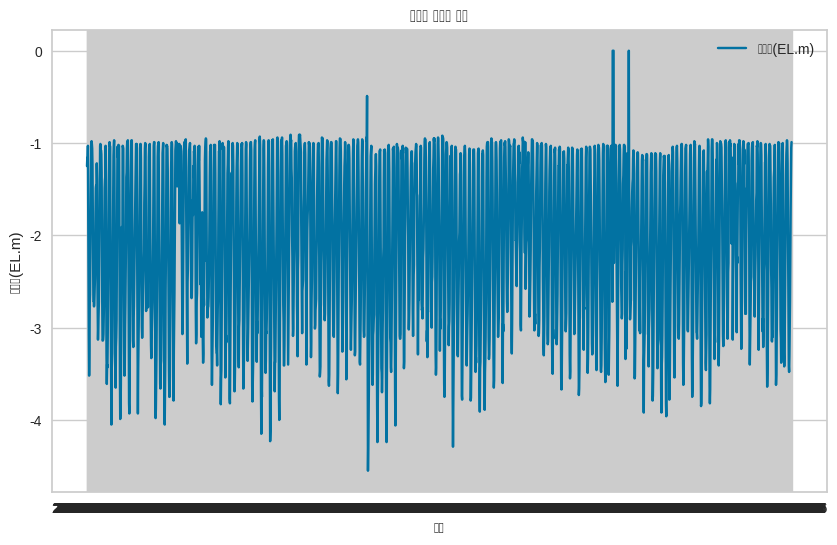

<Figure size 800x550 with 0 Axes>

In [ ]:
# 호수위(EL.m) 시계열 데이터 시각화
plt.figure(figsize=(10, 6))
plt.plot(df1['일자'], df1['호수위(EL.m)'], label='호수위(EL.m)')
plt.xlabel('일자')
plt.ylabel('호수위(EL.m)')
plt.title('시화호 호수위 변화')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('시화호 호수위 변화.png')

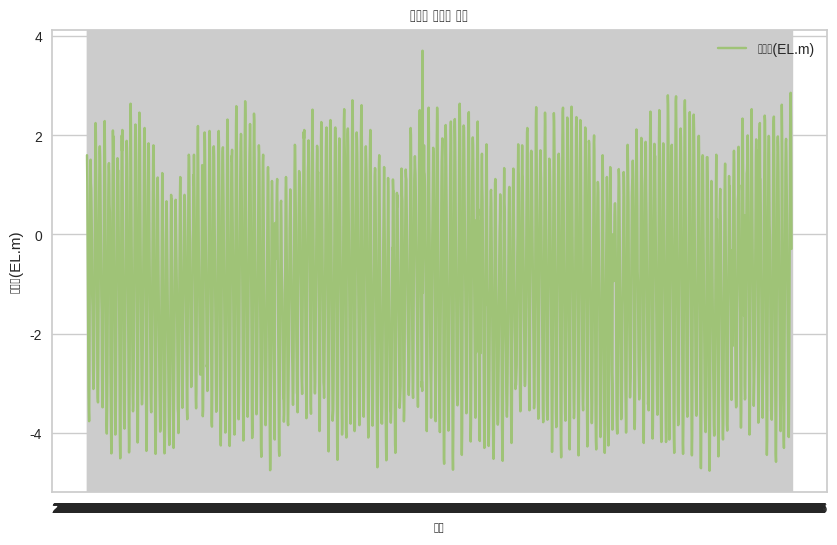

<Figure size 800x550 with 0 Axes>

In [ ]:
# 해수위(EL.m) 시계열 데이터 시각화
plt.figure(figsize=(10, 6))
plt.plot(df1['일자'], df1['해수위(EL.m)'], label='해수위(EL.m)', c = 'g')
plt.xlabel('일자')
plt.ylabel('해수위(EL.m)')
plt.title('시화호 해수위 변화')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('시화호 해수위 변화.png')

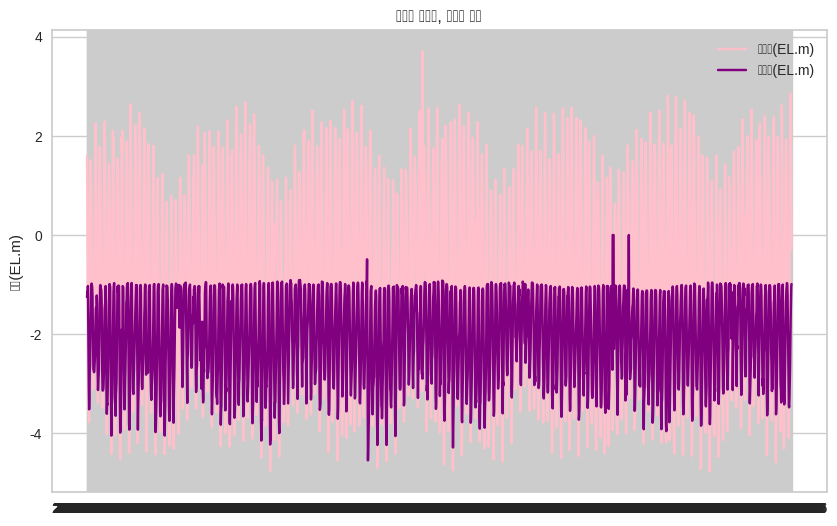

<Figure size 800x550 with 0 Axes>

In [ ]:
# 호수위(EL.m), 해수위 시계열 데이터 한번에 시각화
plt.figure(figsize=(10, 6))


plt.plot(df1['일자'], df1['해수위(EL.m)'], label='해수위(EL.m)', c = 'pink')
plt.plot(df1['일자'], df1['호수위(EL.m)'], label='호수위(EL.m)', c = 'purple')

plt.ylabel('수위(EL.m)')
plt.title('시화호 호수위, 해수위 변화')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('시화호 해수위 호수위 변화.png')

In [ ]:
df1 = df1.set_index('일자')

### 2-2.df2

In [ ]:
df2 = merged_wq_df

In [ ]:
df2.head()

,일자,호수위(EL.m),해수위(EL.m),우량(mm),평균기온(°C),최저기온(°C),최고기온(°C),평균 풍속(m/s),전기전도도,수온,...,탁도,일사량,염분,클로로필,화학적산소요구량,총질소,총인,암모니아질소,질산질소,인산성인
0,2021-12-31,-2.33,0.78,0.0,-5.9,-10.5,-2.2,1.7,28.90,4.80,...,4.0,0.0,32.80,0.52,1.36,0.368,0.046,0.090,0.260,0.034
1,2021-12-30,-1.71,1.76,0.0,-3.3,-9.1,0.7,1.4,29.29,5.30,...,2.0,0.0,32.78,0.21,1.05,0.421,0.045,0.114,0.259,0.034
2,2021-12-29,-1.24,2.19,1.0,0.2,-7.7,7.4,0.9,29.21,5.31,...,9.0,0.0,32.67,0.74,0.84,0.435,0.047,0.122,0.313,0.034
3,2021-12-28,-1.04,1.46,0.0,-4.9,-11.8,1.1,0.4,29.36,5.51,...,5.0,0.0,32.66,0.45,1.25,0.000,0.044,0.132,0.408,0.034
4,2021-12-27,-1.04,0.47,0.0,-8.4,-15.6,-3.2,0.5,29.41,5.67,...,13.0,0.0,32.57,0.44,1.83,0.554,0.051,0.089,0.239,0.034


In [ ]:
df2 = df2.set_index('일자')

In [ ]:
df2 = df2.drop(['최저기온(°C)',	'최고기온(°C)','평균 풍속(m/s)' ], axis = 1)

In [ ]:
df2.columns

Index(['호수위(EL.m)', '해수위(EL.m)', '우량(mm)', '평균기온(°C)', '전기전도도', '수온', '수소이온농도',
       '용존산소량', '탁도', '일사량', '염분', '클로로필', '화학적산소요구량', '총질소', '총인', '암모니아질소',
       '질산질소', '인산성인'],
      dtype='object')

In [ ]:
df2.rename(columns={'호수위(EL.m)': 'lake level(EL.m)',
                      '해수위(EL.m)': 'Sea level (m)',
                      '우량(mm)': 'Precipitation (mm)',
                      '평균기온(°C)': 'Average temperature (°C)',
                      '전기전도도': 'Electrical conductivity',
                      '수온': 'Water temperature',
                      '수소이온농도': 'pH',
                      '용존산소량': 'DO',
                      '탁도': 'Turb',
                      '일사량': 'SR',
                      '염분': 'Salin',
                      '클로로필': 'Chl-a',
                      '화학적산소요구량': 'COD',
                      '총질소': 'TN',
                      '총인': 'TP',
                      '암모니아질소': 'NH4-N',
                      '질산질소': 'NO3-N',
                      '인산성인': 'PO4-P'}, inplace=True)


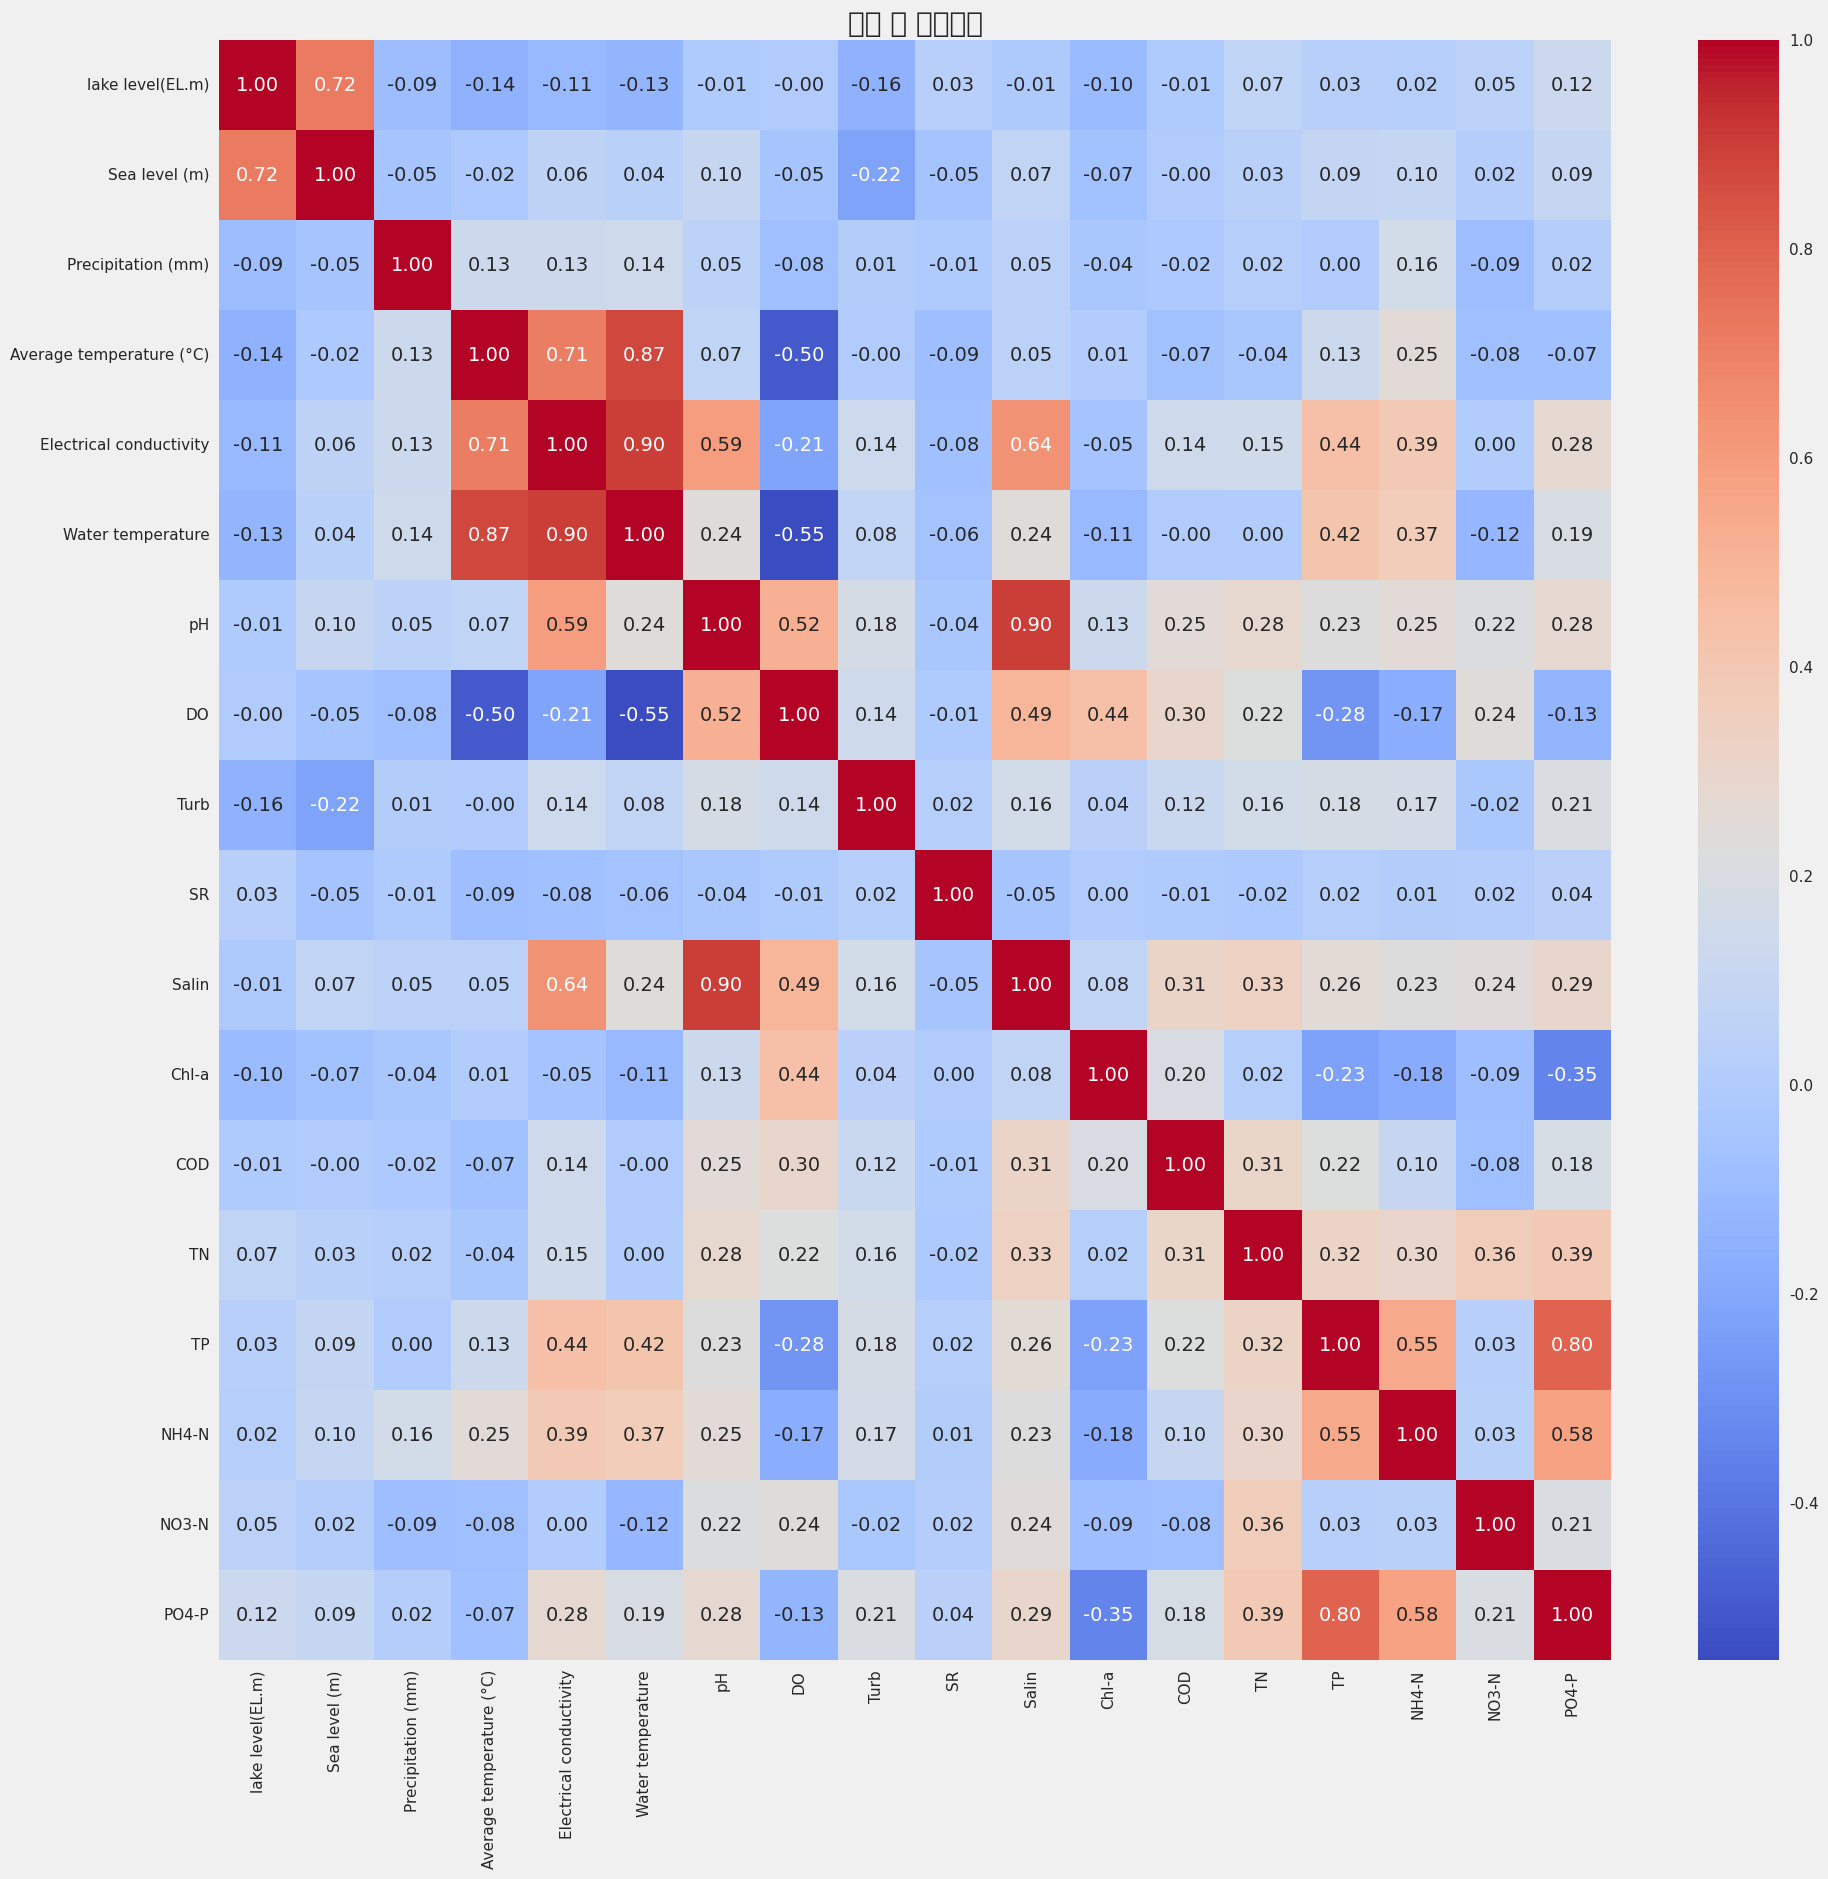

In [ ]:
corr = df2.corr()
# Heatmap 그리기
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("변수 간 상관관계")
plt.show()

In [ ]:
df2_1 = df2.drop(['lake level(EL.m)', 'Sea level (m)', 'Precipitation (mm)', 'SR' ], axis = 1)

In [ ]:
# PyCaret 환경 설정
reg_setup = setup(df2_1, target = 'DO', train_size = 0.8, session_id = 123)

,Description,Value
0,Session id,123
1,Target,DO
2,Target type,Regression
3,Original data shape,"(353, 14)"
4,Transformed data shape,"(353, 14)"
5,Transformed train set shape,"(282, 14)"
6,Transformed test set shape,"(71, 14)"
7,Numeric features,13
8,Rows with missing values,0.3%
9,Preprocess,True


In [ ]:
# 모델 비교 및 생성
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.4271,0.7332,0.8069,0.9158,0.1816,0.0493,0.7580
rf,Random Forest Regressor,0.5598,1.0448,0.9651,0.8734,0.2138,0.0622,0.4590
gbr,Gradient Boosting Regressor,0.5775,1.0719,0.9765,0.8715,0.2164,0.0649,0.3530
xgboost,Extreme Gradient Boosting,0.5667,1.0669,0.9892,0.8711,0.2259,0.0658,0.1860
lr,Linear Regression,0.6701,1.1072,1.0238,0.8572,0.2133,0.0781,0.8420
huber,Huber Regressor,0.6570,1.1550,1.0477,0.8518,0.2154,0.0757,0.1030
lar,Least Angle Regression,0.6928,1.1719,1.0500,0.8493,0.2194,0.0802,0.0880
ridge,Ridge Regression,0.6745,1.1605,1.0539,0.8492,0.2190,0.0779,0.0770
br,Bayesian Ridge,0.6654,1.1605,1.0542,0.8490,0.2165,0.0771,0.1380
dt,Decision Tree Regressor,0.6514,1.3646,1.1276,0.8266,0.2416,0.0829,0.0740


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
# 모델 예측
predictions = predict_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.3776,0.4790,0.6921,0.9454,0.1863,0.0438


In [ ]:
# 모델 평가
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
# feature importance 확인
interpret_model(best_model)

In [ ]:
# 다중 시계열 그래프: 클로로필, 총질소, 총인 변화 시각화
# 그래프를 그리드로 표시
plt.figure(figsize=(12, 8))

# 클로로필 그래프
plt.subplot(3, 3, 1)
plt.plot(df2_2['클로로필'])
plt.title('클로로필 변화')
plt.grid(True)
plt.xticks(rotation = 45)

# 총질소 그래프
plt.subplot(3, 3, 2)
plt.plot(df2_2['총질소'])
plt.title('총질소 변화')
plt.grid(True)
plt.xticks(rotation = 45)

# 총인 그래프
plt.subplot(3, 3, 3)
plt.plot(df2_2['총인'])
plt.title('총인 변화')
plt.grid(True)
plt.xticks(rotation = 45)

# 전기전도도 그래프
plt.subplot(3, 3, 4)
plt.plot(df2_2['전기전도도'])
plt.title('전기전도도 변화')
plt.grid(True)
plt.xticks(rotation = 45)

# 전기전도도 그래프
plt.subplot(3, 3, 5)
plt.plot(df2_2['염분'])
plt.title('염분 변화')
plt.grid(True)
plt.xticks(rotation = 45)

# 전기전도도 그래프
plt.subplot(3, 3, 6)
plt.plot(df2_2['수소이온농도'])
plt.title('수소이온농도')
plt.xticks(rotation = 45)
plt.grid(True)

# 전기전도도 그래프
plt.subplot(3, 3, 7)
plt.plot(df2_2['화학적산소요구량'])
plt.title('화학적산소요구량')
plt.xticks(rotation = 45)
plt.grid(True)

# 전기전도도 그래프
plt.subplot(3, 3, 8)
plt.plot(df2_2['용존산소량'])
plt.xticks(rotation = 45)
plt.title('용존산소량')
plt.grid(True)

# 암모니아질소 그래프
plt.subplot(3, 3, 9)
plt.plot(df2_2['암모니아질소'])
plt.xticks(rotation = 45)
plt.title('암모니아질소')
plt.grid(True)

# 그래프 레이아웃 조정
plt.tight_layout()
# 전체 그래프 표시
plt.show()

plt.savefig('화학성분 추이.png')

In [ ]:
df3_2 = pd.read_csv('https://raw.githubusercontent.com/haileychoii/k-water_ready/main/csv%ED%8C%8C%EC%9D%BC/k-water_%EB%B0%A9%EB%A5%98%EB%9F%89_2.csv', index_col=1)

# df3_2 = pd.read_csv('./csv파일/k-water_방류량_2.csv', index_col=1)

In [ ]:
df3_22 = df3_2.drop(['최저기온(°C)', '최고기온(°C)', '남조류', '규산규소', '기온', '상대습도', '풍속', '풍향', '개문시작시각', '강수량', '폐문종료시각'], axis = 1)

In [ ]:
df3_2.rename(columns={'호수위(EL.m)': 'lake level(EL.m)',
                      '해수위(EL.m)': 'Sea level (m)',
                      '우량(mm)': 'Precipitation (mm)',
                      '평균기온(°C)': 'Average temperature (°C)',
                      '전기전도도': 'Electrical conductivity',
                      '수온': 'Water temperature',
                      '수소이온농도': 'pH',
                      '용존산소량': 'DO',
                      '탁도': 'Turb',
                      '일사량': 'SR',
                      '염분': 'Salin',
                      '클로로필': 'Chl-a',
                      '화학적산소요구량': 'COD',
                      '총질소': 'TN',
                      '총인': 'TP',
                      '암모니아질소': 'NH4-N',
                      '질산질소': 'NO3-N',
                      '인산성인': 'PO4-P',
                      '평균 풍속(m/s)': 'AWS(m/s)',
                      '방류량(천톤)': 'DV(kT)'}, inplace=True)



In [ ]:
corr = df3_22.corr()
# Heatmap 그리기
plt.figure(figsize=(30, 30))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("변수 간 상관관계")
plt.savefig('변수 간 상관관계3.png')
plt.show()


In [ ]:
## pycaret
regression_setup = setup(df3_22, target='DO', normalize=True, train_size=0.8, session_id=111)

In [ ]:
# 모델 비교 및 생성
best_model = compare_models()

In [ ]:
# 모델 예측
predictions = predict_model(best_model)

In [ ]:
# 모델 평가
evaluate_model(best_model)